# Simulation of a positron-induced Muon Source

### Cross section computation:
* *Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$)*

Both differential and total cross section in the CoM reference system are computed in the limit of $\sqrt{s}\sim 2m_\mu \gg m_e$, $m_e$ is thus discarded. $\theta$ is considered as the angle of the outcoming $\mu^+$ with respect to the incoming $e^+$ direction (which we call x axis). The scatttering is planar and the final distribution is isotropic with respect to $\varphi$ angle around x axis.

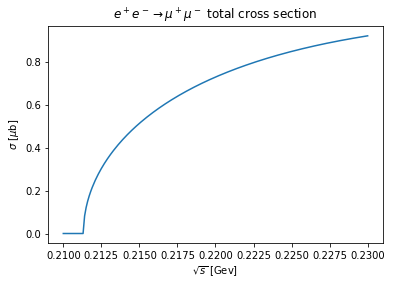

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
e_ = 1.60217662e-19 # C
c_ = 299792458
alpha = 1./137.
mmu = 0.1056583715 # GeV/c2


def xsec(sqrs):      # cross section computed for sqrt(s)~2m_mu, disarding m_e. 
                     # e+e- Center of Mass reference system
    sqrs=np.array(sqrs)
    sqrs_loc=sqrs.copy()
    mask = (sqrs_loc/mmu < 2)    # s is set to inf when less than threshold to have zero cross section
    sqrs_loc[mask] = 9999
    sigma = (4.*pi*alpha**2)/3./(sqrs_loc**2)*np.sqrt(1.-4.*(mmu/sqrs_loc)**2)*(1.+2.*(mmu/sqrs_loc)**2)
    sigma_mub = 389.379 * sigma   # conversion from GeV-2 to mubarn
    return sigma_mub

xx = np.arange(0.21,0.23,0.0001)
yy = xsec(xx)

plt.figure(figsize=(6,4))
plt.subplot(111)
plt.plot(xx,yy)
plt.xlabel(r'$\sqrt{s}$ [Gev]')
plt.ylabel(r'$\sigma$ [$\mu$b]')
plt.title(r'$e^+e^-\rightarrow\mu^+\mu^-$ total cross section')
plt.show()

* *Compute and display the angle and momentum components distributions of the emerging muon pairs.*

The differential cross section is computed as a function of $\cos{\theta}$ to get the angular distributon of produced muon pairs. $\sqrt{s}=0.22$ GeV is taken as example.

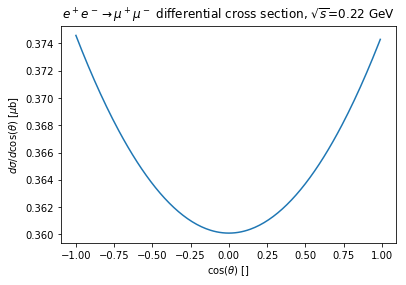

In [3]:
def xsec_diff(sqrs2,cos):   # differential cross section (N.B.: already integrated over phi!!)

    sqrs2=np.array(sqrs2)
    sqrs_loc=sqrs2.copy()
    mask = (sqrs_loc/mmu < 2)
    sqrs_loc[mask] = 9999
    beta = np.sqrt(1.-4.*mmu*mmu/(sqrs_loc**2))
    dsigma = pi/2.*alpha*alpha/(sqrs_loc**2)*beta*(1+(2.*mmu/sqrs_loc)**2+(beta*cos)**2)
    
    return 389.379*dsigma

xxcos=np.arange(-1,1,0.01)

rads=0.22

plt.figure(figsize=(6,4))
plt.subplot(111)
plt.plot(xxcos,xsec_diff(rads,xxcos))
plt.xlabel(r'$\cos{(\theta)}$ []')
plt.ylabel(r'$d\sigma/d\cos{(\theta)}$ [$\mu$b]')
plt.title(r'$e^+e^-\rightarrow\mu^+\mu^-$ differential cross section, $\sqrt{s}$=0.22 GeV')
plt.show()

* *Write a Monte Carlo simulation that generates scattering events following the distrubtions that you find analytically.* 

$\cos{\theta}$ is sampled using the inverse transformation method. The distribution we get is coherent with the one found analytically. The distribution looks "dirt" because at these low energy the curvature of the distribution parabola (i.e. the different probability density for minima and maxima) is very small.

In [4]:
from scipy.optimize import brentq
%precision 8

# ---------- Monte Carlo cosTheta sampling with inverse transformation method -------

N=100000
s=rads**2

def f(x, s, k):
    alpha = 1./137.
    mmu = 0.1056583715
    beta = np.sqrt(1.-4.*(mmu)**2/(s))   ####(alpha/4.*s)*beta*
    return ( ( (1. + (4.*mmu**2)/s + ((beta*x)**2)/3.)*x + 1. + (4.*mmu**2)/s + (beta**2)/3 )/
            (2*(1. + (4.*mmu**2)/s + ((beta)**2)/3.)) - k )


k_arr=np.random.random(N)

cos_arr=[brentq(f, -1, 1, args=(s, kk)) for kk in k_arr]

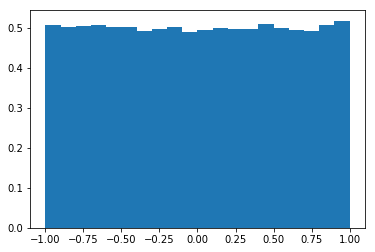

In [5]:
plt.hist(cos_arr, bins=20, density=True)
#plt.ylim(0.45, 0.55)
plt.show()

$\varphi$ angle is sampled from a uniform distribution from 0 to $2\pi$.

In [6]:
# ------ Monte Carlo phi sampling from uniform distribution -------
phi = 2*pi*np.random.random(N)

An alternative methond to sample $\cos\theta$ is the "rejection sampling" (Accept-reject method). The result is very similar to what was obtained with previous method, thus in this case the procedures are equivalent. The analitycal distribution is plotted on top for comparison.

(0.45000000, 0.55000000)

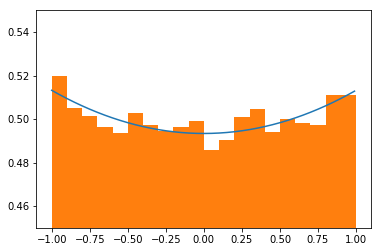

In [7]:
from scipy.integrate import quad
%precision 8

rads=0.22

def xsec_diff_norm(cos, sqrs2):   # differential cross section (N.B.: already integrated over phi!!)
    alpha = 1./137.
    mmu = 0.1056583715 # GeV/c2
    sqrs2=np.array(sqrs2)
    
    sqrs_loc=sqrs2.copy()
    mask = (sqrs_loc/mmu < 2)
    sqrs_loc[mask] = 9999
    beta = np.sqrt(1.-4.*mmu*mmu/(sqrs_loc**2))
    dsigma = pi/2.*alpha*alpha/(sqrs_loc**2)*beta*(1+(2.*mmu/sqrs_loc)**2+(beta*cos)**2)
    
    return 389.379*dsigma/xsec(sqrs2)

plt.plot(xxcos,xsec_diff_norm(xxcos,rads))


upper = xsec_diff_norm(-1, rads)


u = np.random.uniform(-1, 1, N)
r = np.random.uniform(0, upper, N)
v = u[r < xsec_diff_norm(u,rads)]

plt.hist(v, bins=20, density=True)
plt.ylim(0.45, 0.55)



* *About $N=10^5$ (or more) of such events should be produced and listed as rows in a file with 6 columns representing the muon pair tri-momenta*

We produce a dataframe of $N=10^5$ events getting the momentum components in the CoM r.f. The beam energy was chosen to be $\sqrt{s}=0.22$ GeV/c$^2$

In [8]:
import pandas as pd

# ------ preliminar dataset creation -------

data = pd.DataFrame(
    {
        'cosTheta': cos_arr,
        'phi': phi
    }
)

data['sinTheta'] = np.sqrt(1-data['cosTheta']**2)


In [9]:
p = np.sqrt( rads**2/(2)**2 - mmu**2 )

momentum = pd.DataFrame()

momentum['p1x'] = p*data['sinTheta']*np.cos(data['phi'])
momentum['p1y'] = p*data['cosTheta']*np.sin(data['phi'])
momentum['p1z'] = p*data['cosTheta']

momentum['p2x'] = -momentum['p1x']
momentum['p2y'] = -momentum['p1y']
momentum['p2z'] = -momentum['p1z']

momentum.head()

,p1x,p1y,p1z,p2x,p2y,p2z
0,0.030050,-0.000356,0.005425,-0.030050,0.000356,-0.005425
1,0.029035,-0.000063,0.009656,-0.029035,0.000063,-0.009656
2,0.026774,0.003607,-0.012357,-0.026774,-0.003607,0.012357
3,0.000274,0.012473,0.012474,-0.000274,-0.012473,-0.012474
4,0.014044,-0.016533,0.022886,-0.014044,0.016533,-0.022886


Momenta are boosted in the laboratory frame with a lorentz transformation along the z-axis (incoming positron direction). The final momenta are printed in a .csv file called "pencil-beam.csv".

In [14]:
me = 0.000511 # GeV/c^2

beta_rel = - np.sqrt( 1. - (4.*me**2)/rads**2 )
gamma_rel = 1./np.sqrt(1-beta_rel**2)

mom_lab_frame = pd.DataFrame()

mom_lab_frame['p1x'] = momentum['p1x']
mom_lab_frame['p1y'] = momentum['p1y']
mom_lab_frame['p1z'] = gamma_rel*momentum['p1z'] - beta_rel*gamma_rel*rads/2
mom_lab_frame['p2x'] = momentum['p2x']
mom_lab_frame['p2y'] = momentum['p2y']
mom_lab_frame['p2z'] = gamma_rel*momentum['p2z'] - beta_rel*gamma_rel*rads/2

mom_lab_frame.to_csv("pencil-beam.csv")

mom_lab_frame.head()

,p1x,p1y,p1z,p2x,p2y,p2z
0,0.012688,-0.001939,30.047538,-0.012688,0.001939,17.310072
1,0.022037,-0.000091,26.677731,-0.022037,0.000091,20.679880
2,0.018946,-0.008514,29.958018,-0.018946,0.008514,17.399593
3,0.000223,0.019233,27.819214,-0.000223,-0.019233,19.538396
4,0.022921,-0.007706,25.974987,-0.022921,0.007706,21.382624


* *Assume a $6$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.*

The interaction rate is computed by calculating and integrating the instant luminosity: $L = n_e \frac{\rho_{Be} N_A}{AM_{Be}}\Delta l_{Be} R_{e^+}$, where $n_e$ is the number of electrons per atom, $\rho_{Be}$ is the Beryllium density, $N_A$ is the Avogadro number, $AM_{Be}$ is the Beryllium atomic mass, $\Delta l_{Be}$ is the target thickness, and $R_{e^+}$ is the positron impacting on the target per second. 

In this way: $N_{event}= \sigma(s) * L * t$.

In [16]:
rhoBe = 1848e3 # g/m^3
amBe = 9.012182 # u
thikBe = 0.06 # m
ratePos = 1e6
n_av = 6.022e23

L = 4 * ((rhoBe * n_av) / amBe) * thikBe * ratePos

Rate = xsec(rads) * 1e-34 * L

evt_week = Rate * 7 * 24 * 60 * 60

scaling_factor = evt_week/N

print("acaling factor: ",scaling_factor)

acaling factor:  13.081858869906545


* *Repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV.*

The energy spread is sampled in the laboratory rest frame from a normal distribution. Since the sampling of $\cos{\theta}$ is performed in the Lab r.f. we had to first boost the positron "central" energy to the lab frame, sample N energies according to the gaussian distribution, and then boost them back in the CoM rf where the $\cos{\theta}$ were assigned to each event according to the differential cross section related to their resulting energy. The so-obtained momenta were then boosted another time to the Lab frame and printed in a csv file "uniform-beam.csv".

The transverse spread of the beam is sampled by generating a random radius (uniform normal distribution from 0 to 1 cm) and a random angle (uniform distribution from 0 to $2\pi$).


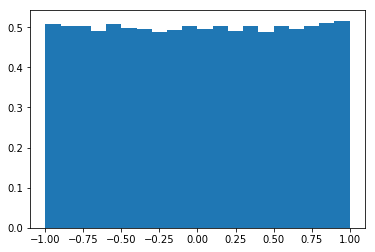

In [11]:
%precision 8
N = 100000
sigma_en = 0.5
T_boil_Be = 2742 # K
rads = 0.22


beta_rel = - np.sqrt( 1. - (4.*me**2)/rads**2 )
gamma_rel = 1./np.sqrt(1-beta_rel**2)
en_lab = gamma_rel * rads / 2. - beta_rel * gamma_rel * np.sqrt( rads**2/4 - me**2 )
en_lab_arr = np.random.normal(en_lab, sigma_en, N)

rads_arr = 2 * (gamma_rel * en_lab_arr + beta_rel * gamma_rel * np.sqrt( en_lab_arr**2 - me**2 ))
mask = (rads_arr < 2*mmu)
rads_arr[mask] = 99999

p_arr = np.sqrt( rads_arr**2/(2)**2 - mmu**2 )
p_arr[mask] = 0

k_arr_en = np.random.random(N)
costh_arr = [brentq(f, -1, 1, args=(ss**2, kk)) for ss,kk in zip(rads_arr, k_arr_en)]


plt.hist(costh_arr, bins=20, density=True)
plt.show()

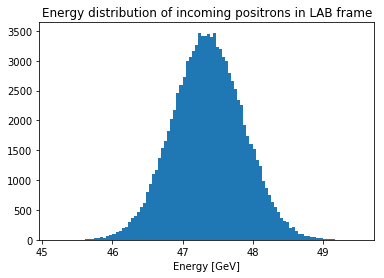

In [48]:
data = pd.DataFrame(
    {
        'cosTheta': costh_arr,
        'phi': phi
    }
)

data['sinTheta'] = np.sqrt(1-data['cosTheta']**2)


momentum = pd.DataFrame()

momentum['p1x'] = p_arr*data['sinTheta']*np.cos(data['phi'])
momentum['p1y'] = p_arr*data['cosTheta']*np.sin(data['phi'])
momentum['p1z'] = p_arr*data['cosTheta']

momentum['p2x'] = -momentum['p1x']
momentum['p2y'] = -momentum['p1y']
momentum['p2z'] = -momentum['p1z']



plt.hist(en_lab_arr,bins=100)
plt.title("Energy distribution of incoming positrons in LAB frame")
plt.xlabel("Energy [GeV]")
plt.show()

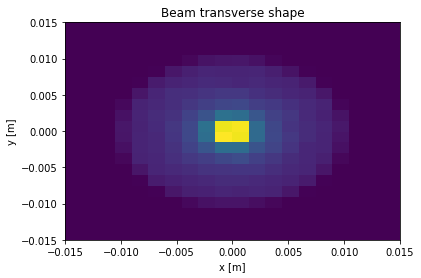

In [50]:
radius = 0.01 * np.random.random(N)
ang = 2*pi*np.random.random(N)

position = pd.DataFrame()

position['x1'] = radius * np.cos(ang)
position['y1'] = radius * np.sin(ang)
position['z1'] = 0.

position['x2'] = position['x1']
position['y2'] = position['y1']
position['z2'] = 0.

xspread1 = np.array(position['x1'])
yspread1 = np.array(position['y1'])

plt.hist2d(xspread1,yspread1,bins=20,range=((-0.015,0.015),(-0.015,0.015)),normed=True)
plt.title("Beam transverse shape")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

In [52]:
beta_rel_arr = - np.sqrt( 1. - (4.*me**2)/rads_arr**2 )
gamma_rel_arr = 1./np.sqrt(1-beta_rel_arr**2)

mom_lab_frame = pd.DataFrame()

mom_lab_frame['p1x'] = momentum['p1x']
mom_lab_frame['p1y'] = momentum['p1y']
mom_lab_frame['p1z'] = gamma_rel_arr*momentum['p1z'] - beta_rel_arr*gamma_rel_arr*rads_arr/2
mom_lab_frame['p2x'] = momentum['p2x']
mom_lab_frame['p2y'] = momentum['p2y']
mom_lab_frame['p2z'] = gamma_rel_arr*momentum['p2z'] - beta_rel_arr*gamma_rel_arr*rads_arr/2

mom_lab_frame.to_csv("uniform-beam.csv")

mom_lab_frame.head()

,p1x,p1y,p1z,p2x,p2y,p2z
0,0.012688,-0.001939,30.271003,-0.012688,0.001939,17.480655
1,0.022037,-0.000091,26.143677,-0.022037,0.000091,20.209756
2,0.018946,-0.008514,30.637796,-0.018946,0.008514,17.921092
3,0.000223,0.019233,27.710671,-0.000223,-0.019233,19.447323
4,0.022921,-0.007706,26.541750,-0.022921,0.007706,21.897251


* *Assume a $2$ meter long, $1.7$ Tesla dipole magnet is placed right after the target. Display the occupancy of the muon hits on a tracking detector placed at 6 meters after the dipole.*

The muons perform a circular motion in the dipole and a linear uniform motion in the drift. We calculated the final momentum components (after the dipole region) using relativistic cinematic, while for the final coordinates we used trigonometry considerations. We assume the magnetic field to be oriented along the x axis.

In [53]:
B = 1.7 # T
l_d = 2 # m
d_track = 6 #m


p1_arr_lab_2 = mom_lab_frame['p1x']**2+mom_lab_frame['p1y']**2+mom_lab_frame['p1z']**2
p2_arr_lab_2 = mom_lab_frame['p2x']**2+mom_lab_frame['p2y']**2+mom_lab_frame['p2z']**2
#print(p1_arr_lab_2)
p_f = pd.DataFrame()

p_f['p1x'] = mom_lab_frame['p1x']
p_f['p1y'] = mom_lab_frame['p1y'] + B * e_ * l_d / 5.344286e-19
p_f['p1z'] = np.sqrt(p1_arr_lab_2 - p_f['p1y']**2 - p_f['p1x']**2)

p_f['p2x'] = mom_lab_frame['p2x']
p_f['p2y'] = mom_lab_frame['p2y'] - B * e_ * l_d / 5.344286e-19
p_f['p2z'] = np.sqrt(p2_arr_lab_2 - p_f['p2y']**2 - p_f['p2x']**2)

In [54]:
beta_rel_mu1_arr = np.sqrt(p1_arr_lab_2)/np.sqrt(p1_arr_lab_2 + mmu**2) 
beta_rel_mu2_arr = np.sqrt(p2_arr_lab_2)/np.sqrt(p2_arr_lab_2 + mmu**2) 

gamma_rel_mu1_arr = 1. / np.sqrt( 1. - beta_rel_mu1_arr**2 )
gamma_rel_mu2_arr = 1. / np.sqrt( 1. - beta_rel_mu2_arr**2 )


In [55]:
omega = pd.DataFrame({
    'mu1': (B*c_**2) / (mmu * 1e9 * gamma_rel_mu1_arr),
    'mu2': (-B*c_**2) / (mmu * 1e9 * gamma_rel_mu2_arr)
})


# mu+

R = (np.sqrt(mom_lab_frame['p1y']**2+mom_lab_frame['p1z']**2)*1e9)/(1.7*c_)
th_mu = np.arctan(mom_lab_frame['p1y']/mom_lab_frame['p1z'])
mask = th_mu>0

D = 2./np.cos(th_mu)
ct = np.cos(pi/2 - th_mu)
L1 = (-2*R/ct + np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
L2 = (-2*R/ct - np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
d_y = L2**2/(2*R)
d_y[mask] = 0
d_y_1 = d_y/np.sin(pi/2-th_mu) + position['y1']
d_y_1[mask] = 0
L2[mask] = 0

t_out_1 = (L2/R) / omega['mu1']


L = 2./np.cos(th_mu)
tth = np.tan(th_mu)


d1 = (-(2*L*tth-2*R)+np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
d2 = (-(2*L*tth-2*R)-np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
mask = th_mu<0
d_y_2 = d2/np.cos(th_mu) + 2*np.tan(th_mu) + position['y1']
d_y_2[mask] = 0
d2[mask] = 0
L[mask] = 0
t_out_2 = ((L + d2*tth)/R) / omega['mu1']

t_out = t_out_1 + t_out_2


x_out_mu1 = mom_lab_frame['p1x'] * t_out / (mmu * gamma_rel_mu1_arr) + position['x1']
y_out_mu1 = d_y_1 + d_y_2


pos_f = pd.DataFrame({
    'x1': x_out_mu1,
    'y1': y_out_mu1,
    'z1': 2.
})


t_drift = 6./(c_*p_f['p1z']/(mmu*gamma_rel_mu1_arr))

pos_tracker = pd.DataFrame({
    'x1': pos_f['x1'] + t_drift * c_*p_f['p1x']/(mmu*gamma_rel_mu1_arr),
    'y1': pos_f['y1'] + t_drift * c_*p_f['p1y']/(mmu*gamma_rel_mu1_arr),
    'z1': pos_f['z1'] + t_drift * c_*p_f['p1z']/(mmu*gamma_rel_mu1_arr),
})



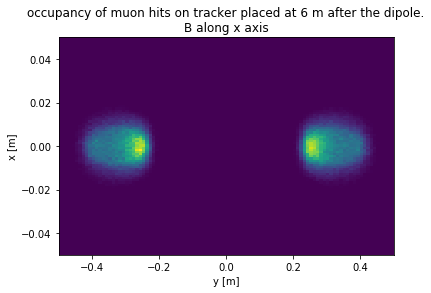

In [61]:
R = -(np.sqrt(mom_lab_frame['p2y']**2+mom_lab_frame['p2z']**2)*1e9)/(1.7*c_)
th_mu = np.arctan(mom_lab_frame['p2y']/mom_lab_frame['p2z'])
mask = th_mu<0

D = 2./np.cos(th_mu)
ct = np.cos(pi/2 - th_mu)
L1 = (-2*R/ct + np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
L2 = (-2*R/ct - np.sqrt(4*R**2/ct**2 + 8*R*D/ct))/2
d_y = L2**2/(2*R)
d_y[mask] = 0
d_y_1 = d_y/np.sin(pi/2-th_mu) + position['y2']
d_y_1[mask] = 0
L2[mask] = 0

t_out_1 = (L2/R) / omega['mu2']


L = 2./np.cos(th_mu)
tth = np.tan(th_mu)


d1 = (-(2*L*tth-2*R)+np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
d2 = (-(2*L*tth-2*R)-np.sqrt((2*L*tth-2*R)**2-4*(L*tth)**2))/(2*tth**2)
mask = th_mu>0
d_y_2 = d1/np.cos(th_mu) + 2*np.tan(th_mu) + position['y2']
d_y_2[mask] = 0
d1[mask] = 0
L[mask] = 0
t_out_2 = ((L + d1*tth)/R) / omega['mu2']

t_out = t_out_1 + t_out_2


x_out_mu1 = mom_lab_frame['p2x'] * t_out / (mmu * gamma_rel_mu1_arr) + position['x2']
y_out_mu1 = d_y_1 + d_y_2


pos_f = pd.DataFrame({
    'x2': x_out_mu1,
    'y2': y_out_mu1,
    'z2': 2.
})


t_drift = 6./(c_*p_f['p2z']/(mmu*gamma_rel_mu1_arr))

pos_tracker['x2'] = pos_f['x2'] + t_drift * c_*p_f['p2x']/(mmu*gamma_rel_mu1_arr)
pos_tracker['y2'] = pos_f['y2'] + t_drift * c_*p_f['p2y']/(mmu*gamma_rel_mu1_arr)
pos_tracker['z2'] = pos_f['z2'] + t_drift * c_*p_f['p2z']/(mmu*gamma_rel_mu1_arr)


x_arr = np.append(np.array(pos_tracker['x1']), np.array(pos_tracker['x2']))
y_arr = np.append(np.array(pos_tracker['y1']), np.array(pos_tracker['y2']))

plt.hist2d(y_arr, x_arr, range=((-0.5,0.5),(-0.05,0.05)), bins=100)
plt.title("Occupancy of muon hits on tracker placed at 6 m after the dipole.\nB along x axis")
plt.xlabel("y [m]")
plt.ylabel("x [m]")
plt.show()